Bước 1: Khám phá tập dữ liệu
Thư mục train có chưa 43 thư mục con mỗi thư mục đại diện cho một lớp khác nhau được đánh số thứ tự từ 0 đến 42. sử dụng module OS ta sẽ lặp lại trên tất cả các lớp để kết nối các hình ảnh với nhãn tương ứng của chúng.

Thư viện PIL được sử dụng để chuyển hình ảnh thành một mảng.

In [1]:
# pip install numpy pandas matplotlib opencv-python tensorflow pillow scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score
from keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
# 1️⃣ Load and Preprocess Data
data = []
labels = []
classes = 43
cur_path = os.getcwd()

for i in range(classes):
    path = os.path.join(cur_path, 'train', str(i))
    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(os.path.join(path, a))
            image = image.resize((30, 30))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except Exception as e:
            print(f"Error loading image {a}: {e}")

data = np.array(data)
labels = np.array(labels)
print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")

Data shape: (78418, 30, 30, 3), Labels shape: (78418,)


Sau đó ta sẽ lưu tất cả các hình ảnh và nhãn của chúng vào lists data và labels.

Chúng ta cần chuyển các lists thành các numpy array để làm đầu vào cho model.

Kích thước của dữ liệu là  (39209, 30, 30, 3), có nghĩa là có 39209 hình ảnh, mỗi ảnh có kích thước 30x30 pixel, số 3 ở cuối thể hiện dữ liệu là hình ảnh màu (giá trị RGB).

Sử dụng phương thức train_test_split () của sklearn để phân chia bộ dữ liệu thành train set và test set.

Sử dụng phương thức to_categorical của keras.utils để xử lý các nhãn của y_train và y_test bằng one-hot encoding.

In [3]:
# 2️⃣ Split Data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, classes)
y_test = to_categorical(y_test, classes)
print(f"Train shapes: {X_train.shape}, {y_train.shape}")
print(f"Test shapes: {X_test.shape}, {y_test.shape}")

Train shapes: (62734, 30, 30, 3), (62734, 43)
Test shapes: (15684, 30, 30, 3), (15684, 43)


Bước 2: Xây dựng mô hình CNN
Để phân loại các hình ảnh thành các danh mục tương ứng, chúng ta sẽ xây dựng mô hình CNN (Convolutional Neural Network). CNN là mô hình tốt nhất cho mục đích phân loại hình ảnh.

Kiến trúc mô hình CNN của chúng ta như sau:

2 Conv2D layer (filter=32, kernel_size=(5,5), activation=”relu”)
MaxPool2D layer ( pool_size=(2,2))
Dropout layer (rate=0.25)
2 Conv2D layer (filter=64, kernel_size=(3,3), activation=”relu”)
MaxPool2D layer ( pool_size=(2,2))
Dropout layer (rate=0.25)
Flatten layer to squeeze the layers into 1 dimension
Dense Fully connected layer (256 nodes, activation=”relu”)
Dropout layer (rate=0.5)
Dense layer (43 nodes, activation=”softmax”)

In [4]:
# 3️⃣ Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='nearest'
)
datagen.fit(X_train)

Sau khi xây dựng kiến trúc mô hình, chúng ta sẽ huấn luyện mô hình bằng cách sử dụng model.fit (). Chúng ta hãy thử với batch size là 32 và 64. nhận thấy mô hình hoạt động tốt hơn với batch size là 64. và sau 15 epochs độ chính xác đã được ổn định.

In [5]:
# 4️⃣ Build Model
model = Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(32, (5, 5), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (5, 5), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(43, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 899,403 (3.43 MB)

 Trainable params: 898,507 (3.43 MB)

 Non-trainable params: 896 (3.50 KB)

None


Mô hình của chúng ta đã đạt đến độ chính xác ~ 95% trên tập training set. Sử dụng matplotlib để vẽ biểu đồ tương quan giữa độ chính xác và sự mất mát.

In [6]:
# 6️⃣ Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# 7️⃣ Train Model
epochs = 3
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, early_stopping]  # Sử dụng callbacks đã định nghĩa
)

Epoch 1/3


C:\Users\XUAN HIEP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


114/981 ━━━━━━━━━━━━━━━━━━━━ 2:07 147ms/step - accuracy: 0.1370 - loss: 3.8919

KeyboardInterrupt: 

In [9]:
# 6️⃣ Save and Evaluate Model
model.save("traffic_classifier123.h5")

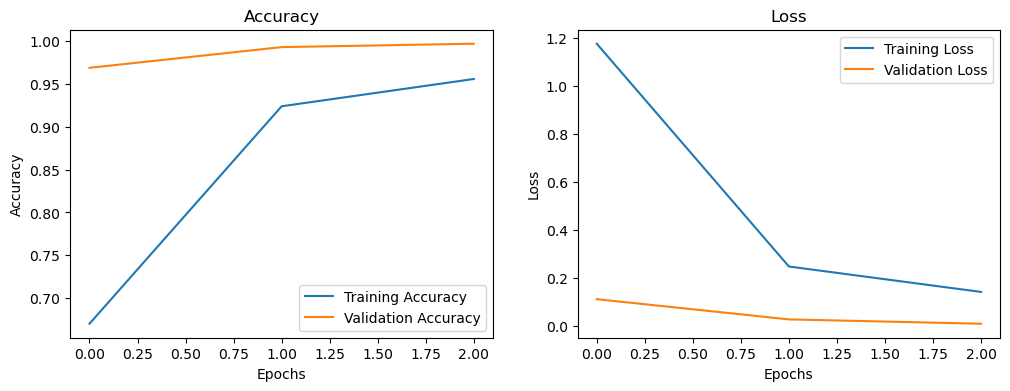

In [10]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# 7️⃣ Test Model
model = load_model("traffic_classifier.h5")
pred = model.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
accuracy = accuracy_score(np.argmax(y_test, axis=1), pred_classes)
print(f"Test Accuracy: {accuracy}")

491/491 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step
Test Accuracy: 0.9912649834225963
